In [1]:
import os
import sqlite3

import geopandas as gpd
import folium as fl
import pandas as pd
from collections import OrderedDict
from datetime import datetime
from rich import print


In [2]:
#read different polygons to use them later to select stations from the forecast and observations
fyn_pol = gpd.read_file("polygons/around_fyn.geojson")

nwz_pol = gpd.read_file("polygons/around_nw_zealand.geojson")
mju_pol = gpd.read_file("polygons/somewhere_midjutland.geojson")
all_stations = gpd.read_file("all_vejvejr_stations_2023.shp")

stations = OrderedDict()

#select math with all stations in the selected regions
stations["fyn"] = gpd.sjoin(all_stations,fyn_pol,predicate="within")
stations["mju"] = gpd.sjoin(all_stations,mju_pol,predicate="within")
stations["nwz"] = gpd.sjoin(all_stations,nwz_pol,predicate="within")


#this is to get the station coordinates
dbase="data/stations_coords_height.db"
con=sqlite3.connect(dbase)
com="SELECT * FROM roadstations"
df_stations = pd.read_sql(com,con)
con.close()

In [3]:
#cycles to read
cycles= [str(i).zfill(2) for i in range(25)]
cycles=["21","22","23","01","02","03"]
YYYY="2022"
MM="03"

DATA="/home/cap/Downloads/ROAD_MODEL_DATA"

In [4]:
def read_sqlite(dbase:str, table:str) -> pd.DataFrame:
    con=sqlite3.connect(dbase)
    com=f"SELECT * FROM {table}"
    df = pd.read_sql(com,con)
    con.close()
    df["datetime"] = pd.to_datetime(df["validdate"],unit="s")
    if table == "FC":
        df["fcstdatetime"] = pd.to_datetime(df["fcdate"],unit="s")
    # the station list I get above only identifies the first 4 digits (ie, station but not sensor)
    # add this information below as a new column
    df["SID_partial"] = [int(str(sid)[0:4]) for sid in df.SID]
    
    gpd_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")
    return gpd_df

#def read_obs(dbase:str,table:str) -> pd.DataFrame:
    

In [5]:
fcst_data=OrderedDict()

for cycle in cycles:
    fname=os.path.join(DATA,"FCTABLE_DATA",f"FCTABLE_TROAD_{YYYY}{MM}_{cycle}.sqlite")
    print(fname)
    fcst_data[cycle] = read_sqlite(fname,"FC")
    
obs_data = read_sqlite(os.path.join(DATA,f"OBSTABLE_TROAD_{YYYY}.sqlite"),"SYNOP")

/home/cap/Downloads/ROAD_MODEL_DATA/FCTABLE_DATA/FCTABLE_TROAD_202203_21.sqlite

/home/cap/Downloads/ROAD_MODEL_DATA/FCTABLE_DATA/FCTABLE_TROAD_202203_22.sqlite

/home/cap/Downloads/ROAD_MODEL_DATA/FCTABLE_DATA/FCTABLE_TROAD_202203_23.sqlite

/home/cap/Downloads/ROAD_MODEL_DATA/FCTABLE_DATA/FCTABLE_TROAD_202203_01.sqlite

/home/cap/Downloads/ROAD_MODEL_DATA/FCTABLE_DATA/FCTABLE_TROAD_202203_02.sqlite

/home/cap/Downloads/ROAD_MODEL_DATA/FCTABLE_DATA/FCTABLE_TROAD_202203_03.sqlite

In [6]:
#dates=pd.to_datetime(fcst_sel["mju_22"]["fcdate"],unit="s")

In [7]:
fcst_data["22"][["datetime","fcstdatetime"]].iloc[0]

datetime       2022-03-01 23:00:00
fcstdatetime   2022-03-01 00:00:00
Name: 0, dtype: datetime64[ns]

In [8]:
#select only a subset for each domain
#NOTE: this is selecting ALL stations inside the corresponding polygon, irrespective
# of creation date.
fcst_sel = OrderedDict()
obs_sel = OrderedDict()
for key in stations.keys():
    st_group = stations[key]["SID"].to_list()
    obs_sel[key] = obs_data[obs_data["SID_partial"].isin(st_group)]
    #print(st_group)
    for cycle in cycles:
        #for hour in [i for in range(7)]:
        #sel_hour = fcst_data[cycle]
        fcst_sel[key+"_"+cycle] = fcst_data[cycle][fcst_data[cycle]["SID_partial"].isin(st_group)]


In [9]:
fcst_sel["mju_22"].columns

Index(['SID', 'validdate', 'glatmodel_det', 'p', 'lon', 'lat',
       'model_elevation', 'leadtime', 'fcdate', 'parameter', 'units',
       'datetime', 'fcstdatetime', 'SID_partial', 'geometry'],
      dtype='object')

In [10]:
fcst_sel["mju_22"][["fcstdatetime","leadtime","SID"]].tail(10)

,fcstdatetime,leadtime,SID
606470,2022-04-01,13,516700
606471,2022-04-01,14,516700
606472,2022-04-01,15,516700
606473,2022-04-01,16,516700
606474,2022-04-01,17,516700
606475,2022-04-01,18,516700
606476,2022-04-01,19,516700
606477,2022-04-01,20,516700
606478,2022-04-01,21,516700
606479,2022-04-01,22,516700


In [11]:
fcst_sel["mju_23"][["fcstdatetime","leadtime"]].head(10)

,fcstdatetime,leadtime
324720,2022-03-02,0
324721,2022-03-02,1
324722,2022-03-02,2
324723,2022-03-02,3
324724,2022-03-02,4
324725,2022-03-02,5
324726,2022-03-02,6
324727,2022-03-02,7
324728,2022-03-02,8
324729,2022-03-02,9


In [12]:
obs_sel["mju"]

,validdate,SID,lat,lon,elev,TROAD,datetime,SID_partial,geometry
278834,1640984400,400601,56.292120,9.321430,65.922127,6.6,2021-12-31 21:00:00,4006,POINT (9.32143 56.29212)
278835,1640988000,400601,56.292120,9.321430,65.922127,6.4,2021-12-31 22:00:00,4006,POINT (9.32143 56.29212)
278836,1640991600,400601,56.292120,9.321430,65.922127,6.1,2021-12-31 23:00:00,4006,POINT (9.32143 56.29212)
278837,1640995200,400601,56.292120,9.321430,65.922127,5.9,2022-01-01 00:00:00,4006,POINT (9.32143 56.29212)
278838,1640998800,400601,56.292120,9.321430,65.922127,5.8,2022-01-01 01:00:00,4006,POINT (9.32143 56.29212)
...,...,...,...,...,...,...,...,...,...
1197616,1648749600,516501,56.467834,9.414621,42.493500,3.1,2022-03-31 18:00:00,5165,POINT (9.41462 56.46783)
1197617,1648753200,516501,56.467834,9.414621,42.493500,1.6,2022-03-31 19:00:00,5165,POINT (9.41462 56.46783)
1197618,1648756800,516501,56.467834,9.414621,42.493500,0.6,2022-03-31 20:00:00,5165,POINT (9.41462 56.46783)
1197619,1648760400,516501,56.467834,9.414621,42.493500,-0.1,2022-03-31 21:00:00,5165,POINT (9.41462 56.46783)


In [234]:
#select a given date
#for st_cyc in ["mju_21","mju_22","mju_23"]
#first_hours = [datetime(2022,3,2,hour) for hour in range(0,7)]

sel_date = datetime(2022,3,2)

plot0=fcst_sel["mju_21"][(fcst_sel["mju_21"]["fcstdatetime"] == sel_date)&(fcst_sel["mju_21"]["leadtime"] == 0)]
plot1=fcst_sel["mju_21"][(fcst_sel["mju_21"]["fcstdatetime"] == sel_date)&(fcst_sel["mju_21"]["leadtime"] == 1)]
plot2=fcst_sel["mju_21"][(fcst_sel["mju_21"]["fcstdatetime"] == sel_date)&(fcst_sel["mju_21"]["leadtime"] == 2)]
plot3=fcst_sel["mju_21"][(fcst_sel["mju_21"]["fcstdatetime"] == sel_date)&(fcst_sel["mju_21"]["leadtime"] == 3)]
plot4=fcst_sel["mju_21"][(fcst_sel["mju_21"]["fcstdatetime"] == sel_date)&(fcst_sel["mju_21"]["leadtime"] == 4)]
plot5=fcst_sel["mju_21"][(fcst_sel["mju_21"]["fcstdatetime"] == sel_date)&(fcst_sel["mju_21"]["leadtime"] == 5)]
plot6=fcst_sel["mju_21"][(fcst_sel["mju_21"]["fcstdatetime"] == sel_date)&(fcst_sel["mju_21"]["leadtime"] == 6)]
#for hour in [range(7)]:
sel_dates = plot0["datetime"].to_list()
plot_obs0 = obs_sel["mju"][obs_sel["mju"]["datetime"].isin(sel_dates)]

sel_dates = plot1["datetime"].to_list()
plot_obs1 = obs_sel["mju"][obs_sel["mju"]["datetime"].isin(sel_dates)]

sel_dates = plot2["datetime"].to_list()
plot_obs2 = obs_sel["mju"][obs_sel["mju"]["datetime"].isin(sel_dates)]

sel_dates = plot3["datetime"].to_list()
plot_obs3 = obs_sel["mju"][obs_sel["mju"]["datetime"].isin(sel_dates)]

sel_dates = plot4["datetime"].to_list()
plot_obs4 = obs_sel["mju"][obs_sel["mju"]["datetime"].isin(sel_dates)]

#for cycle in ["21","22","23","00","01","02"]:
#    if cycle in ["00","01","03"]
#fcst_sel["mju_22"].shape

In [235]:
#obs_sel["mju"].head(10)

In [236]:
#plot_obs1[["datetime"]]

In [237]:
#plot1["datetime"].to_markdown(index=False)

In [238]:
#plot1["fcstdatetime"].to_list()
#plot2["datetime"].to_list()
#for p in [plot1,plot2,plot3]:
#    print(p["datetime"])

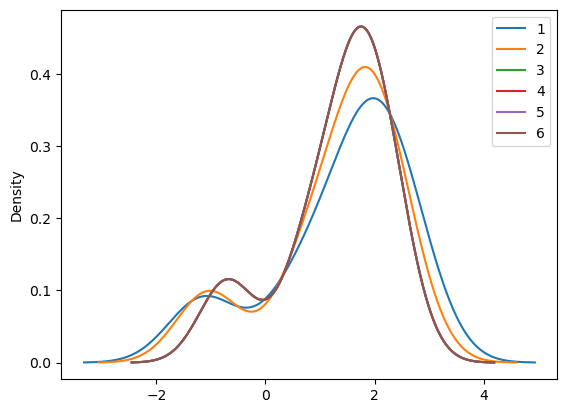

In [239]:
from matplotlib import pyplot as plt
#fig = plt.figure(figsize=[12,9])
fig, ax = plt.subplots()
p1=plot1["glatmodel_det"].plot.density(legend="1")#hist(alpha=0.5)
p2=plot2["glatmodel_det"].plot.density(legend="2")
p3=plot3["glatmodel_det"].plot.density(legend="3")
p4=plot3["glatmodel_det"].plot.density(legend="4")
p5=plot3["glatmodel_det"].plot.density(legend="5")
p6=plot3["glatmodel_det"].plot.density(legend="6")

p1.legend(["1","2","3","4","5","6"])


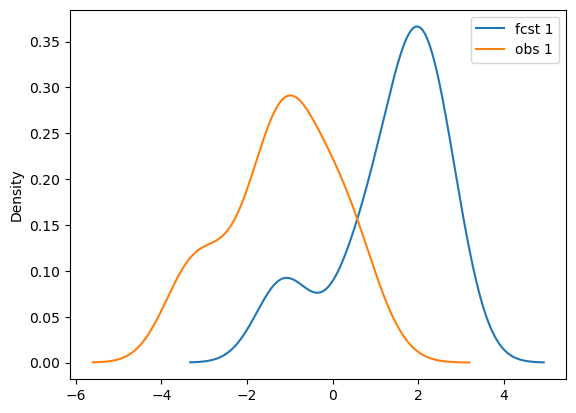

In [240]:
fig, ax = plt.subplots()
p1=plot1["glatmodel_det"].plot.density(legend="1")
p2=plot_obs1["TROAD"].plot.density(legend="1")
p1.legend(["fcst 1","obs 1"])


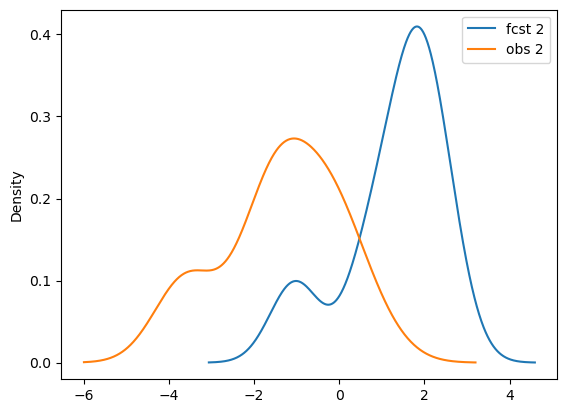

In [241]:
fig, ax = plt.subplots()
p1=plot2["glatmodel_det"].plot.density(legend="2")
p2=plot_obs2["TROAD"].plot.density(legend="2")
p1.legend(["fcst 2","obs 2"])


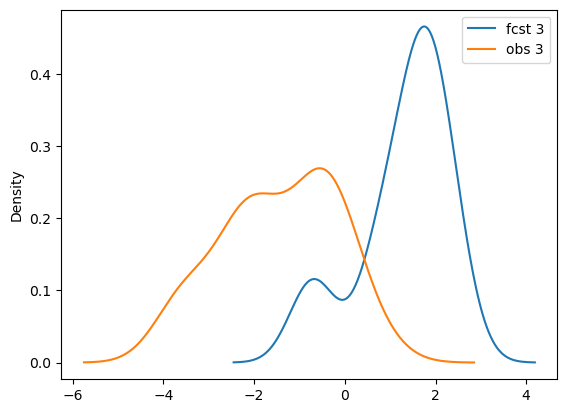

In [242]:
fig, ax = plt.subplots()
p1=plot3["glatmodel_det"].plot.density(legend="3")
p2=plot_obs3["TROAD"].plot.density(legend="3")
p1.legend(["fcst 3","obs 3"])


In [231]:
sel_date = datetime(2022,3,3)
plot1=fcst_sel["mju_21"][(fcst_sel["mju_21"]["fcstdatetime"] == sel_date)&(fcst_sel["mju_21"]["leadtime"] == 1)]
plot2=fcst_sel["mju_21"][(fcst_sel["mju_21"]["fcstdatetime"] == sel_date)&(fcst_sel["mju_21"]["leadtime"] == 2)]
plot3=fcst_sel["mju_21"][(fcst_sel["mju_21"]["fcstdatetime"] == sel_date)&(fcst_sel["mju_21"]["leadtime"] == 3)]
plot4=fcst_sel["mju_21"][(fcst_sel["mju_21"]["fcstdatetime"] == sel_date)&(fcst_sel["mju_21"]["leadtime"] == 4)]
plot5=fcst_sel["mju_21"][(fcst_sel["mju_21"]["fcstdatetime"] == sel_date)&(fcst_sel["mju_21"]["leadtime"] == 5)]
plot6=fcst_sel["mju_21"][(fcst_sel["mju_21"]["fcstdatetime"] == sel_date)&(fcst_sel["mju_21"]["leadtime"] == 6)]


sel_dates = plot1["datetime"].to_list()
plot_obs1 = obs_sel["mju"][obs_sel["mju"]["datetime"].isin(sel_dates)]

sel_dates = plot2["datetime"].to_list()
plot_obs2 = obs_sel["mju"][obs_sel["mju"]["datetime"].isin(sel_dates)]

sel_dates = plot3["datetime"].to_list()
plot_obs3 = obs_sel["mju"][obs_sel["mju"]["datetime"].isin(sel_dates)]

sel_dates = plot4["datetime"].to_list()
plot_obs4 = obs_sel["mju"][obs_sel["mju"]["datetime"].isin(sel_dates)]


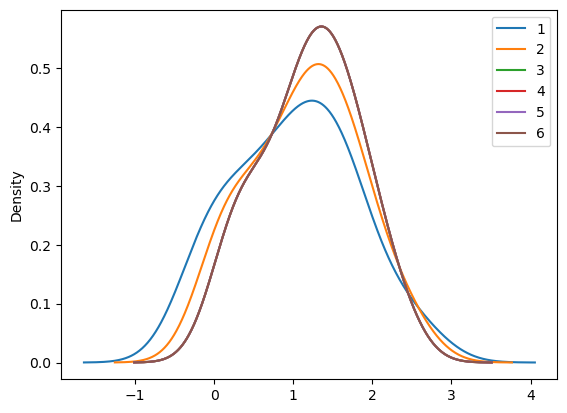

In [187]:
fig, ax = plt.subplots()
p1=plot1["glatmodel_det"].plot.density(legend="1")#hist(alpha=0.5)
p2=plot2["glatmodel_det"].plot.density(legend="2")
p3=plot3["glatmodel_det"].plot.density(legend="3")
p4=plot3["glatmodel_det"].plot.density(legend="4")
p5=plot3["glatmodel_det"].plot.density(legend="5")
p6=plot3["glatmodel_det"].plot.density(legend="6")

p1.legend(["1","2","3","4","5","6"])


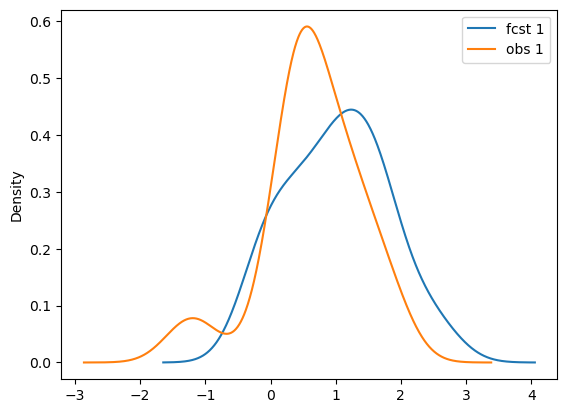

In [232]:
fig, ax = plt.subplots()
p1=plot1["glatmodel_det"].plot.density(legend="1")
p2=plot_obs1["TROAD"].plot.density(legend="1")
p1.legend(["fcst 1","obs 1"])


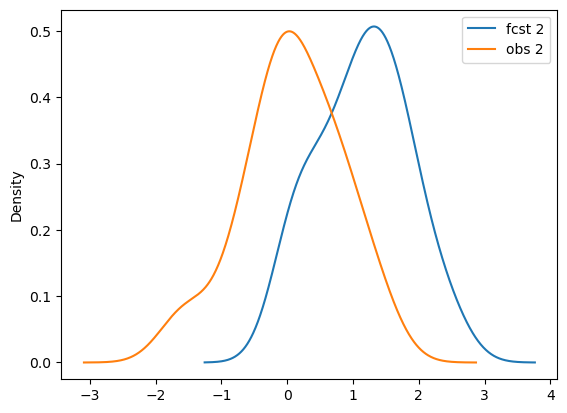

In [233]:
fig, ax = plt.subplots()
p1=plot2["glatmodel_det"].plot.density(legend="1")
p2=plot_obs2["TROAD"].plot.density(legend="1")
p1.legend(["fcst 2","obs 2"])


# Trying to organize the plots a bit better below

In [61]:
sel_date = datetime(2022,3,3)
pol_hour = "mju_21"
plt_fcst = OrderedDict()
for leadtime in range(1,7):
    plt_fcst[leadtime] = fcst_sel[pol_hour][(fcst_sel[pol_hour]["fcstdatetime"] == sel_date)&(fcst_sel[pol_hour]["leadtime"] == leadtime)]


In [62]:
pol_name="mju"
plt_obs = OrderedDict()
for leadtime in range(1,7):
     sel_dates = plt_fcst[leadtime]["datetime"].to_list()
     plt_obs[leadtime] = obs_sel[pol_name][obs_sel[pol_name]["datetime"].isin(sel_dates)]


(-4.0, 4.0)

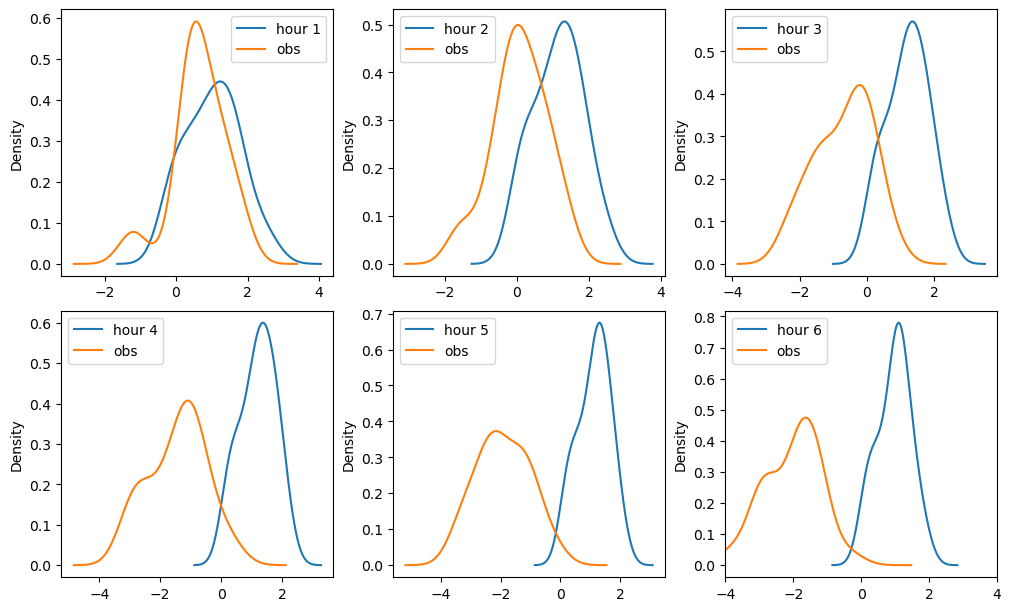

In [72]:
from matplotlib import pyplot as plt
fig = plt.figure(layout="constrained",figsize=(10,6))
mosaic=[["1","2","3"],["4","5","6"]]
ax_dict=fig.subplot_mosaic(mosaic)
#print(ax_dict.keys())
for key in plt_fcst.keys():
    #density = plt_fcst[key]["glatmodel_det"].density()
    #print(key)
    p1=plt_fcst[key]["glatmodel_det"].plot.density(legend=key,ax = ax_dict[str(key)])#.subplot_mosaic()
    plt_obs[key]["TROAD"].plot.density(legend=key,ax = ax_dict[str(key)])
    p1.legend([f"hour {key}", "obs"])    
plt.xlim([-4,4])
    #ax_dict[str(key)].hist(plt_fcst[key]["glatmodel_det"]) #.plot.density(legend="1")

In [52]:
#plt_fcst[1

In [75]:
plt_fcst[key]["glatmodel_det"].std()

0.48762828999797503

In [79]:
sel_date = datetime(2022,3,3)
pol_hour = "fyn_21"
plt_fcst = OrderedDict()
for leadtime in range(1,7):
    plt_fcst[leadtime] = fcst_sel[pol_hour][(fcst_sel[pol_hour]["fcstdatetime"] == sel_date)&(fcst_sel[pol_hour]["leadtime"] == leadtime)]


,SID,validdate,glatmodel_det,p,lon,lat,model_elevation,leadtime,fcdate,parameter,units,datetime,fcstdatetime,SID_partial,geometry
242571,302400,1646269200,2.88,None,10.159734,55.400246,70.643433,1,1646265600,TROAD,degC,2022-03-03 01:00:00,2022-03-03,3024,POINT (10.15973 55.40025)
243315,302401,1646269200,3.01,None,10.159734,55.400246,70.643433,1,1646265600,TROAD,degC,2022-03-03 01:00:00,2022-03-03,3024,POINT (10.15973 55.40025)
244059,302500,1646269200,1.64,None,10.372170,55.353410,18.807562,1,1646265600,TROAD,degC,2022-03-03 01:00:00,2022-03-03,3025,POINT (10.37217 55.35341)
244803,302501,1646269200,1.70,None,10.372170,55.353430,18.756945,1,1646265600,TROAD,degC,2022-03-03 01:00:00,2022-03-03,3025,POINT (10.37217 55.35343)
245547,302502,1646269200,2.07,None,10.372240,55.353590,18.479752,1,1646265600,TROAD,degC,2022-03-03 01:00:00,2022-03-03,3025,POINT (10.37224 55.35359)
246291,302503,1646269200,2.12,None,10.372230,55.353570,18.508001,1,1646265600,TROAD,degC,2022-03-03 01:00:00,2022-03-03,3025,POINT (10.37223 55.35357)
247035,302600,1646269200,1.14,None,10.729110,55.332620,6.678586,1,1646265600,TROAD,degC,2022-03-03 01:00:00,2022-03-03,3026,POINT (10.72911 55.33262)
247779,302601,1646269200,0.69,None,10.729110,55.332630,6.662987,1,1646265600,TROAD,degC,2022-03-03 01:00:00,2022-03-03,3026,POINT (10.72911 55.33263)
248523,302700,1646269200,1.64,None,9.945133,55.307230,14.484014,1,1646265600,TROAD,degC,2022-03-03 01:00:00,2022-03-03,3027,POINT (9.94513 55.30723)
249267,302900,1646269200,2.09,None,10.302030,55.133450,55.504948,1,1646265600,TROAD,degC,2022-03-03 01:00:00,2022-03-03,3029,POINT (10.30203 55.13345)


In [82]:
pol_name="fyn"
plt_obs = OrderedDict()
for leadtime in range(1,7):
     sel_dates = plt_fcst[leadtime]["datetime"].to_list()
     plt_obs[leadtime] = obs_sel[pol_name][obs_sel[pol_name]["datetime"].isin(sel_dates)]


(-4.0, 4.0)

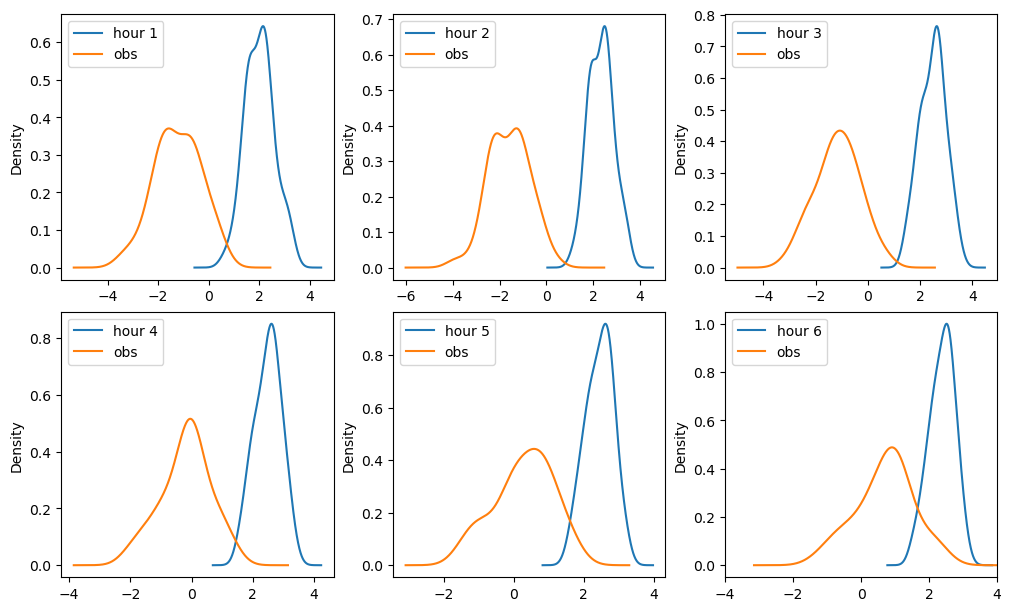

In [84]:
from matplotlib import pyplot as plt
fig = plt.figure(layout="constrained",figsize=(10,6))
mosaic=[["1","2","3"],["4","5","6"]]
ax_dict=fig.subplot_mosaic(mosaic)
#print(ax_dict.keys())
for key in plt_fcst.keys():
    #density = plt_fcst[key]["glatmodel_det"].density()
    #print(key)
    p1=plt_fcst[key]["glatmodel_det"].plot.density(legend=key,ax = ax_dict[str(key)])#.subplot_mosaic()
    plt_obs[key]["TROAD"].plot.density(legend=key,ax = ax_dict[str(key)])
    p1.legend([f"hour {key}", "obs"])    
plt.xlim([-4,4])

In [85]:
sel_date = datetime(2022,3,2)
pol_hour = "fyn_21"
plt_fcst = OrderedDict()
for leadtime in range(1,7):
    plt_fcst[leadtime] = fcst_sel[pol_hour][(fcst_sel[pol_hour]["fcstdatetime"] == sel_date)&(fcst_sel[pol_hour]["leadtime"] == leadtime)]
    
pol_name="fyn"
plt_obs = OrderedDict()
for leadtime in range(1,7):
     sel_dates = plt_fcst[leadtime]["datetime"].to_list()
     plt_obs[leadtime] = obs_sel[pol_name][obs_sel[pol_name]["datetime"].isin(sel_dates)]
   

(-4.0, 4.0)

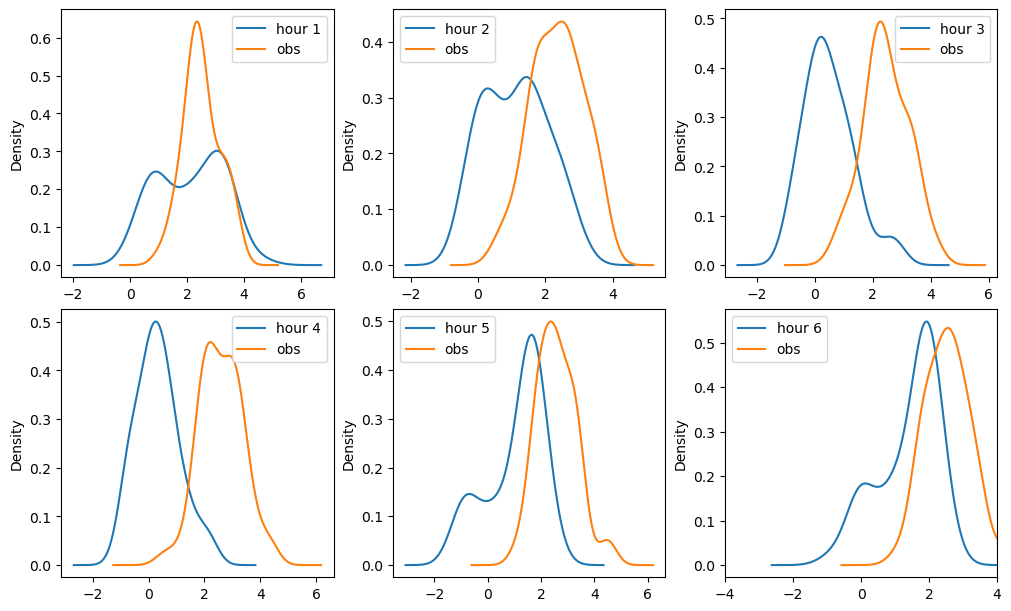

In [86]:
from matplotlib import pyplot as plt
fig = plt.figure(layout="constrained",figsize=(10,6))
mosaic=[["1","2","3"],["4","5","6"]]
ax_dict=fig.subplot_mosaic(mosaic)
#print(ax_dict.keys())
for key in plt_fcst.keys():
    #density = plt_fcst[key]["glatmodel_det"].density()
    #print(key)
    p1=plt_fcst[key]["glatmodel_det"].plot.density(legend=key,ax = ax_dict[str(key)])#.subplot_mosaic()
    plt_obs[key]["TROAD"].plot.density(legend=key,ax = ax_dict[str(key)])
    p1.legend([f"hour {key}", "obs"])    
plt.xlim([-4,4])